In [1]:
import pandas as pd
import h5py
import numpy as np
import pickle
import scipy.io as scio


# import PSCs
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [2]:
with open("../0 save data/2 data_all.pkl",'rb') as f:
    dates, lon, lat, depth, pigments = pickle.load(f)

for var in pigments: print(var,len(pigments[var]),type(pigments[var][0]),end="\t")

fuco 45524 <class 'numpy.float64'>	perid 45524 <class 'numpy.float64'>	hex-fuco 45524 <class 'numpy.float64'>	but-fuco 45524 <class 'numpy.float64'>	allo 45524 <class 'numpy.float64'>	tchl_b 45524 <class 'numpy.float64'>	zea 45524 <class 'numpy.float64'>	tchl_a 45524 <class 'numpy.float64'>	diato 45524 <class 'numpy.float64'>	diadino 45524 <class 'numpy.float64'>	mv_chl_a 45524 <class 'numpy.float64'>	dv_chl_a 45524 <class 'numpy.float64'>	chl_c12 45524 <class 'numpy.float64'>	chl_c3 45524 <class 'numpy.float64'>	neo 45524 <class 'numpy.float64'>	viola 45524 <class 'numpy.float64'>	lut 45524 <class 'numpy.float64'>	pras 45524 <class 'numpy.float64'>	chl_a 45524 <class 'numpy.float64'>	chlide_a 45524 <class 'numpy.float64'>	

### 开始整理数据，去除异常

In [3]:
use_num = len(lat)

use_pigments = {}
for var in pigments:
    use_pigments[var] = np.ones_like(lat,dtype=bool)

### 去除nan数据，保证参数均为数字

In [4]:
pigment_not_nan = np.ones(use_num,dtype=bool)

for var in pigments:
    use_pigments[var] = use_pigments[var] & ~np.isnan(pigments[var])
    pigment_not_nan = pigment_not_nan & ~np.isnan(pigments[var])
print("quantity of all not nan data: ", sum(pigment_not_nan))


quantity of all not nan data:  0


### 去除提取程序中未删除的异常数据

In [5]:
for var in pigments:
    minvalues = (pigments[var]<=0.001)&(pigments[var]>=0)
    pigments[var][minvalues] = 0.001

In [6]:
no_over_dose = np.ones(use_num,dtype=bool)

for var in pigments: 
    use_pigments[var] = use_pigments[var] & (pigments[var]<99)&(pigments[var]>=0)
    no_over_dose = no_over_dose & (pigments[var]<99)&(pigments[var]>=0)
print("quantity of abnormal data: ", sum(no_over_dose))

pigments["chl_a"][pigments["chl_a"]>=pigments["tchl_a"]] = False

quantity of abnormal data:  0


In [7]:
for i in range(len(pigments["dv_chl_a"])):
    if use_pigments["dv_chl_a"][i]:
        if (not use_pigments["tchl_a"][i])&use_pigments["chl_a"][i]:
            pigments["tchl_a"][i] = pigments["chl_a"][i] + pigments["dv_chl_a"][i]
            use_pigments["tchl_a"][i]  =True
        elif (not use_pigments["chl_a"][i])&use_pigments["tchl_a"][i]:
            pigments["chl_a"][i] = pigments["tchl_a"][i] - pigments["dv_chl_a"][i]
            use_pigments["chl_a"][i]  =True  
            
for i in range(len(pigments["dv_chl_a"])):
    if (not use_pigments["chl_a"][i])&use_pigments["mv_chl_a"][i]&use_pigments["mv_chl_a"][i]:
        pigments["chl_a"][i] = pigments["mv_chl_a"][i]+pigments["chlide_a"][i]
        use_pigments["chl_a"][i] = True

### 舍弃depth大于10 和 chla大于-

In [8]:
# depth
depth10 = (depth <= 10)
print("depth use data:{:d}".format(sum(depth10)))

for var in use_pigments: 
    use_pigments[var] = use_pigments[var] & depth10


# tchl_a
tchla33 = (pigments["tchl_a"] <= 30)&(pigments["tchl_a"] >=0.005)
print("tchl_a use data:{:d}".format(sum(tchla33)))

for var in use_pigments: 
    use_pigments[var] = use_pigments[var] & tchla33


depth use data:25217
tchl_a use data:34330


In [9]:
pigment_over = np.ones(use_num,dtype=bool)

for var in pigments: 
    if (var!="tchl_a"):
        use_pigments[var] = use_pigments[var] & (pigments[var]<30.) & (pigments[var]>=0.001)
#         use_pigments[var] = use_pigments[var] & (pigments[var]<pigments["tchl_a"])

use_pigments["fuco"] = use_pigments["fuco"] & (pigments["fuco"]<=pigments["tchl_a"])
use_pigments["allo"] = use_pigments["allo"] & (pigments["allo"]<=pigments["tchl_a"])
use_pigments["zea"] = use_pigments["zea"] & (pigments["zea"]<=pigments["tchl_a"])

In [10]:
# for var in pigments:
#     use_pigments[var][pigments[var]<=0.001] = False


### 删除同一天的数据 

In [11]:
resolution = 24.0

for var in use_pigments:
    anchorS = []
    depth_pool = []
    index_pool = []
    for i in (np.arange(len(use_pigments[var]))[use_pigments[var]]):
        anchor = (dates[i].year,
                  dates[i].month,
                  dates[i].day,
                  np.round(lon[i]*resolution)/resolution,
                  np.round(lat[i]*resolution)/resolution)
        if anchor not in anchorS:
            anchorS.append(anchor)
            depth_pool.append([depth[i]])
            index_pool.append([i])
        else: 
            index = anchorS.index(anchor)
            depth_pool[index].append(depth[i])
            index_pool[index].append(i)
    print(var," data: ", len(anchorS),len(depth_pool),len(index_pool),end="\t")
    print(var," avail day number: ", len(anchorS))
    
    same_day_only_use_one = np.zeros(use_num,dtype=bool)
    for i in range(len(depth_pool)):
        depth_min_index = np.argmin(depth_pool[i])    
        same_day_only_use_one[index_pool[i][depth_min_index]] = True
        
    use_pigments[var] = use_pigments[var] & same_day_only_use_one


fuco  data:  12962 12962 12962	fuco  avail day number:  12962
perid  data:  12475 12475 12475	perid  avail day number:  12475
hex-fuco  data:  12292 12292 12292	hex-fuco  avail day number:  12292
but-fuco  data:  11869 11869 11869	but-fuco  avail day number:  11869
allo  data:  12493 12493 12493	allo  avail day number:  12493
tchl_b  data:  8661 8661 8661	tchl_b  avail day number:  8661
zea  data:  12915 12915 12915	zea  avail day number:  12915
tchl_a  data:  13060 13060 13060	tchl_a  avail day number:  13060
diato  data:  9912 9912 9912	diato  avail day number:  9912
diadino  data:  10775 10775 10775	diadino  avail day number:  10775
mv_chl_a  data:  6742 6742 6742	mv_chl_a  avail day number:  6742
dv_chl_a  data:  7498 7498 7498	dv_chl_a  avail day number:  7498
chl_c12  data:  9473 9473 9473	chl_c12  avail day number:  9473
chl_c3  data:  9267 9267 9267	chl_c3  avail day number:  9267
neo  data:  8420 8420 8420	neo  avail day number:  8420
viola  data:  9272 9272 9272	viola  avail 

In [12]:
for var in use_pigments:
    print(var,use_pigments[var].sum(),end="\t")

fuco 12962	perid 12475	hex-fuco 12292	but-fuco 11869	allo 12493	tchl_b 8661	zea 12915	tchl_a 13060	diato 9912	diadino 10775	mv_chl_a 6742	dv_chl_a 7498	chl_c12 9473	chl_c3 9267	neo 8420	viola 9272	lut 8353	pras 7316	chl_a 9254	chlide_a 9295	

# save data

In [13]:
with open("../0 save data/2 sorted_pigments.pkl", 'wb') as f:
    pickle.dump([dates, lon, lat, depth, pigments, use_pigments], f)

# show some result

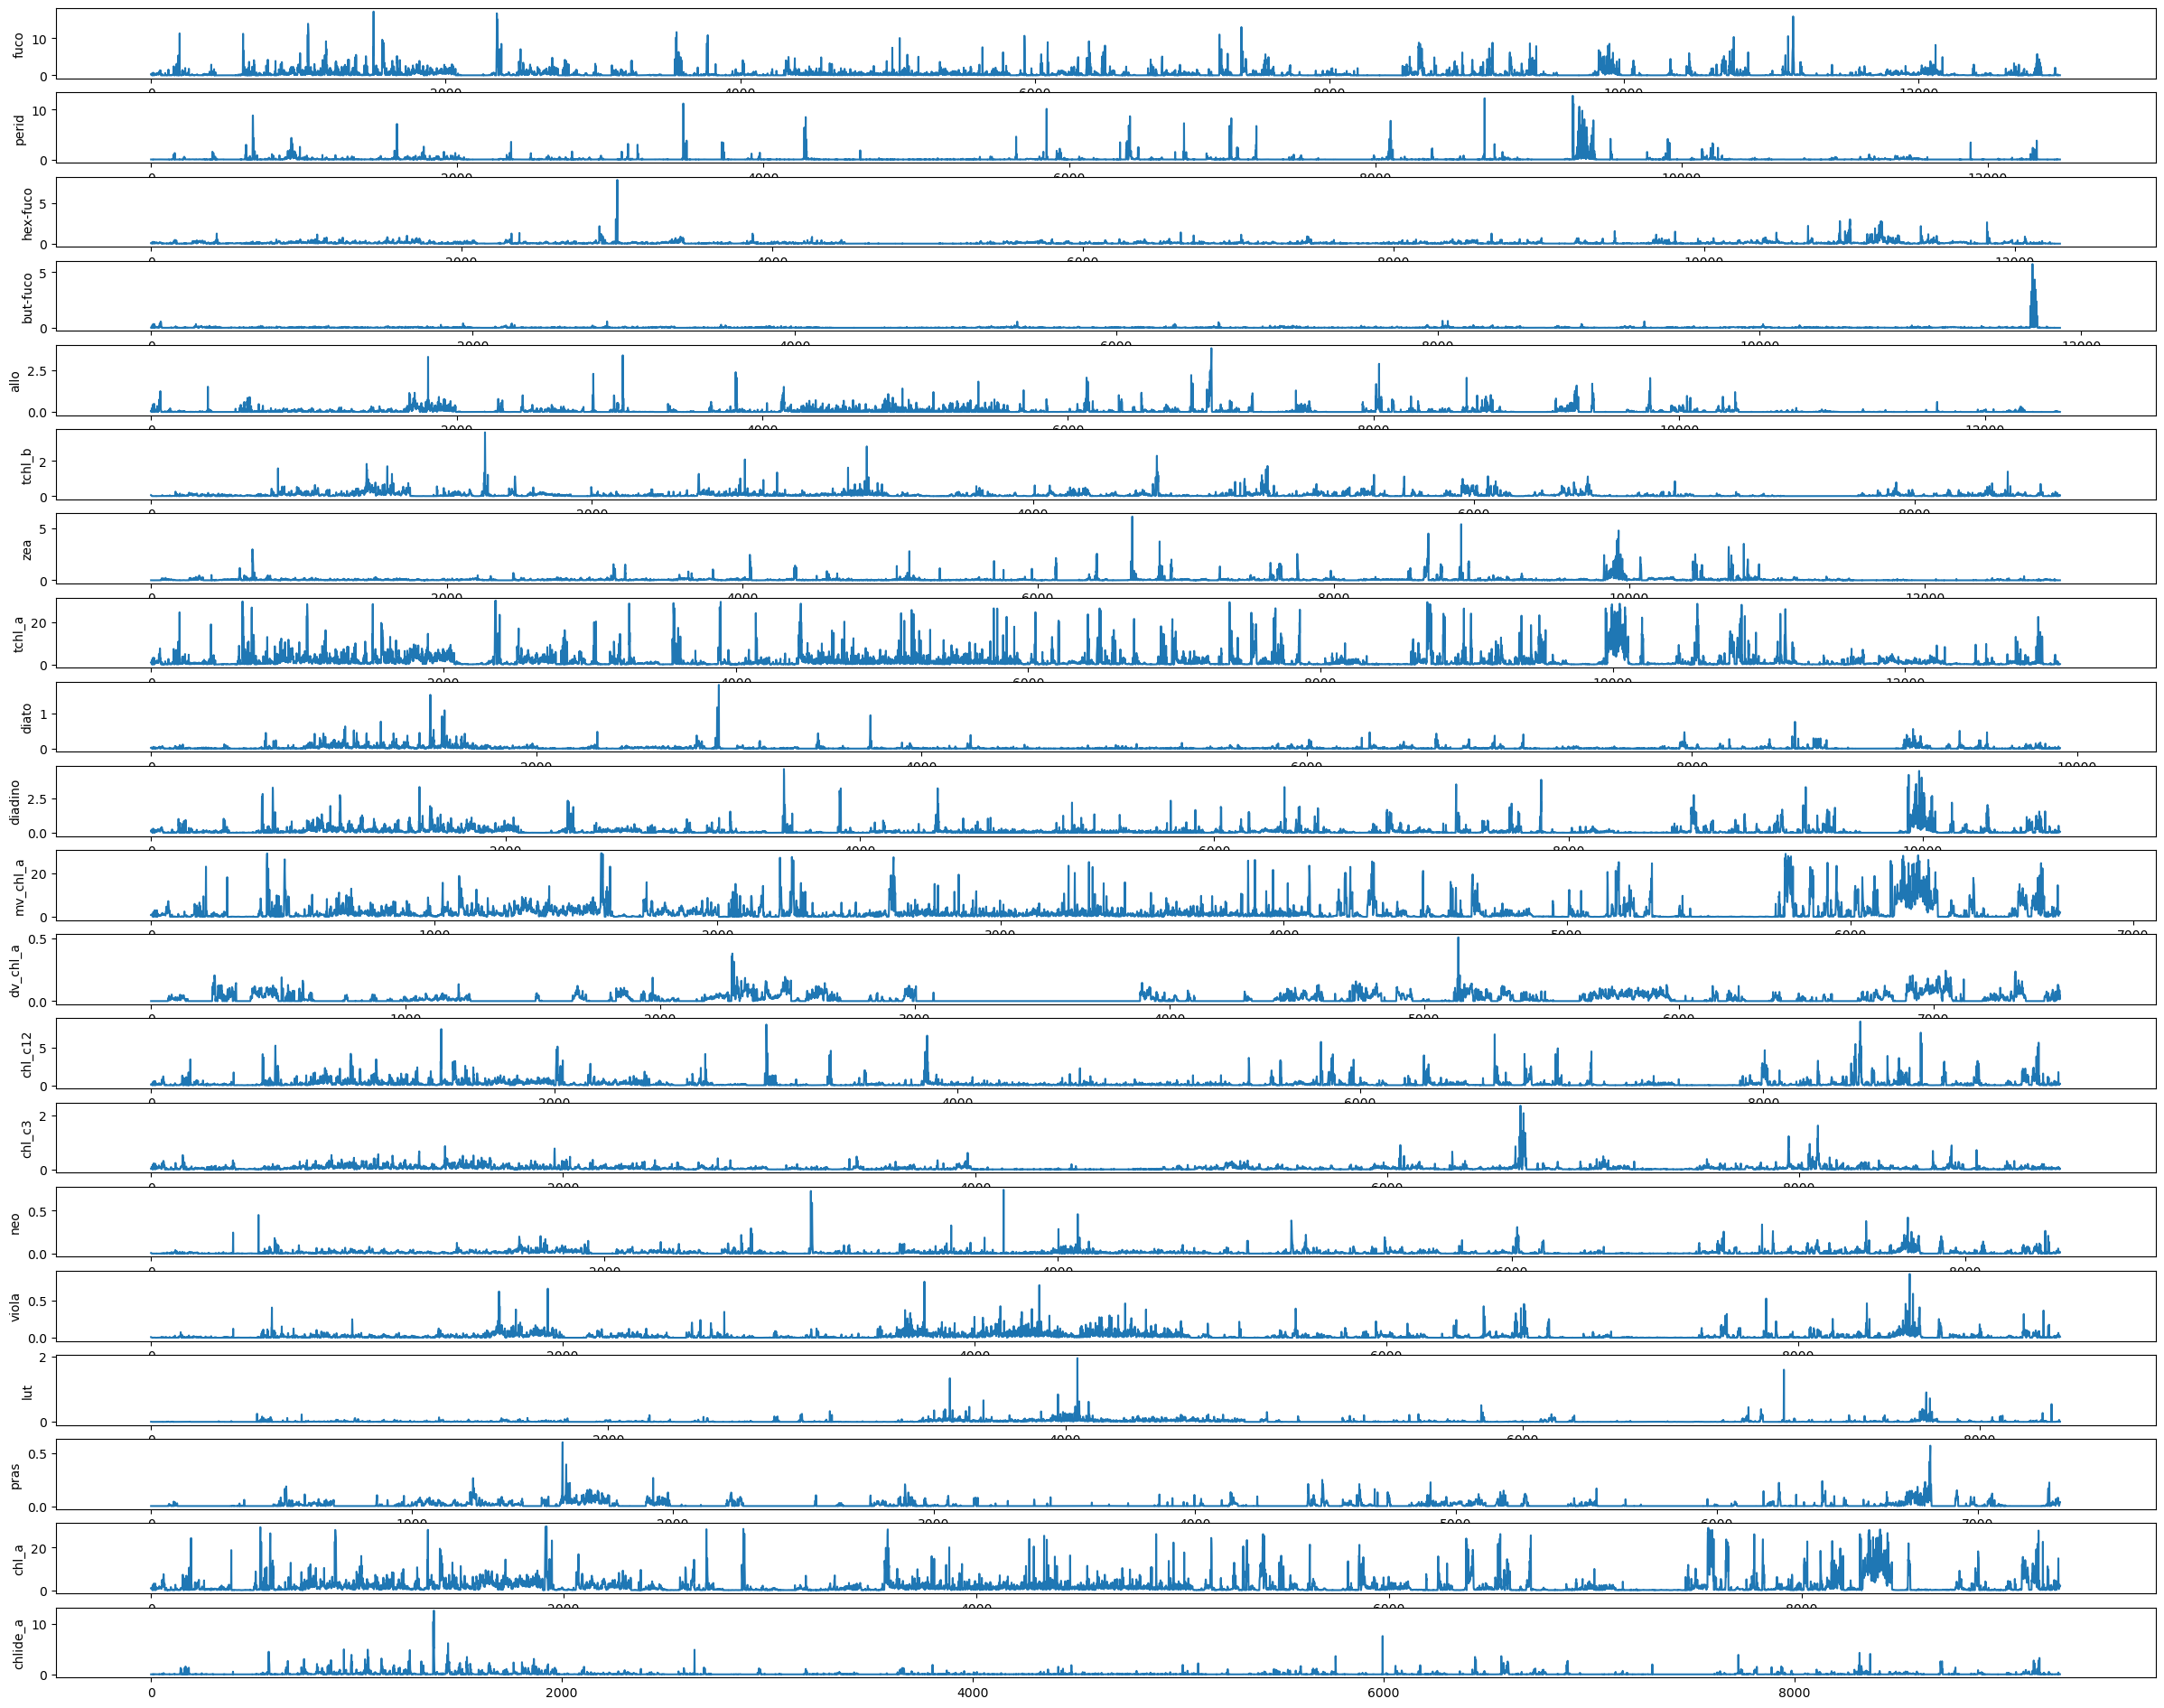

In [14]:
plt.figure(figsize=(30,24))
for i,var in enumerate(pigments):
    plt.subplot(len(pigments),1,i+1)
    plt.plot(pigments[var][use_pigments[var]])
    plt.ylabel(var)

In [15]:
with open("../0 save data/sorted data.txt",'w') as f:
    write_str = "\t".join(["date time","lat","lon","depth"]+list(pigments))
    f.write(write_str+"\n")
    
    for i in range(len(lat)):
        if not use_pigments["tchl_a"][i]:
            continue
        write_str = "\t".join([str(dates[i]),str(lat[i].round(4)),str(lon[i].round(4)),str(depth[i].round(4))])
        f.write(write_str+"\t")
        write_str = "\t".join([str(pigments[var][i].round(4)) if use_pigments[var][i] else str(-999) for var in pigments])
        f.write(write_str+"\n")